In [1]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

In [2]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')

In [ ]:
from google.colab import files
files.upload()

In [4]:
!unzip audiences.zip

Archive:  audiences.zip
  inflating: submission.csv          
  inflating: movies_train.csv        
  inflating: movies_test.csv         


In [6]:
!ls

audiences.zip  movies_test.csv	movies_train.csv  sample_data  submission.csv


In [7]:
data_dir = Path('.')
trn_file = data_dir / 'movies_train.csv'
seed = 42

In [57]:
df = pd.read_csv(trn_file, index_col=0)
print(df.shape)
df.head()

(600, 11)


,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


### EDA

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  270 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


In [59]:
df.fillna(0, inplace=True) # dif_prev_bfnum을 0으로 채워넣음
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  600 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


In [60]:
df.describe() # 수치형 변수만 표출되며 이 데이터셋에서는 모두 양수

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [61]:
target_col = 'box_off_num'
pred_col = 'pred'
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']


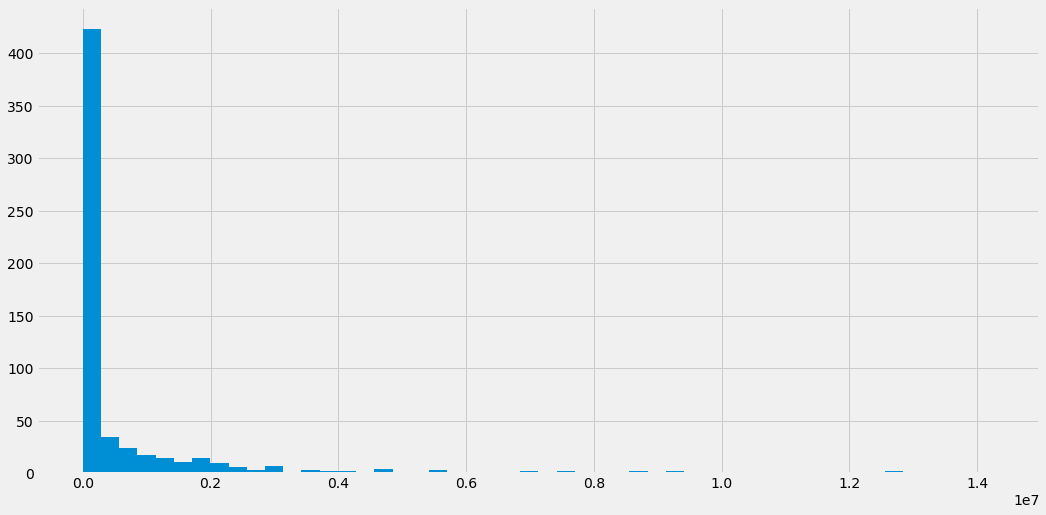

In [62]:
df.box_off_num.hist(bins=50)

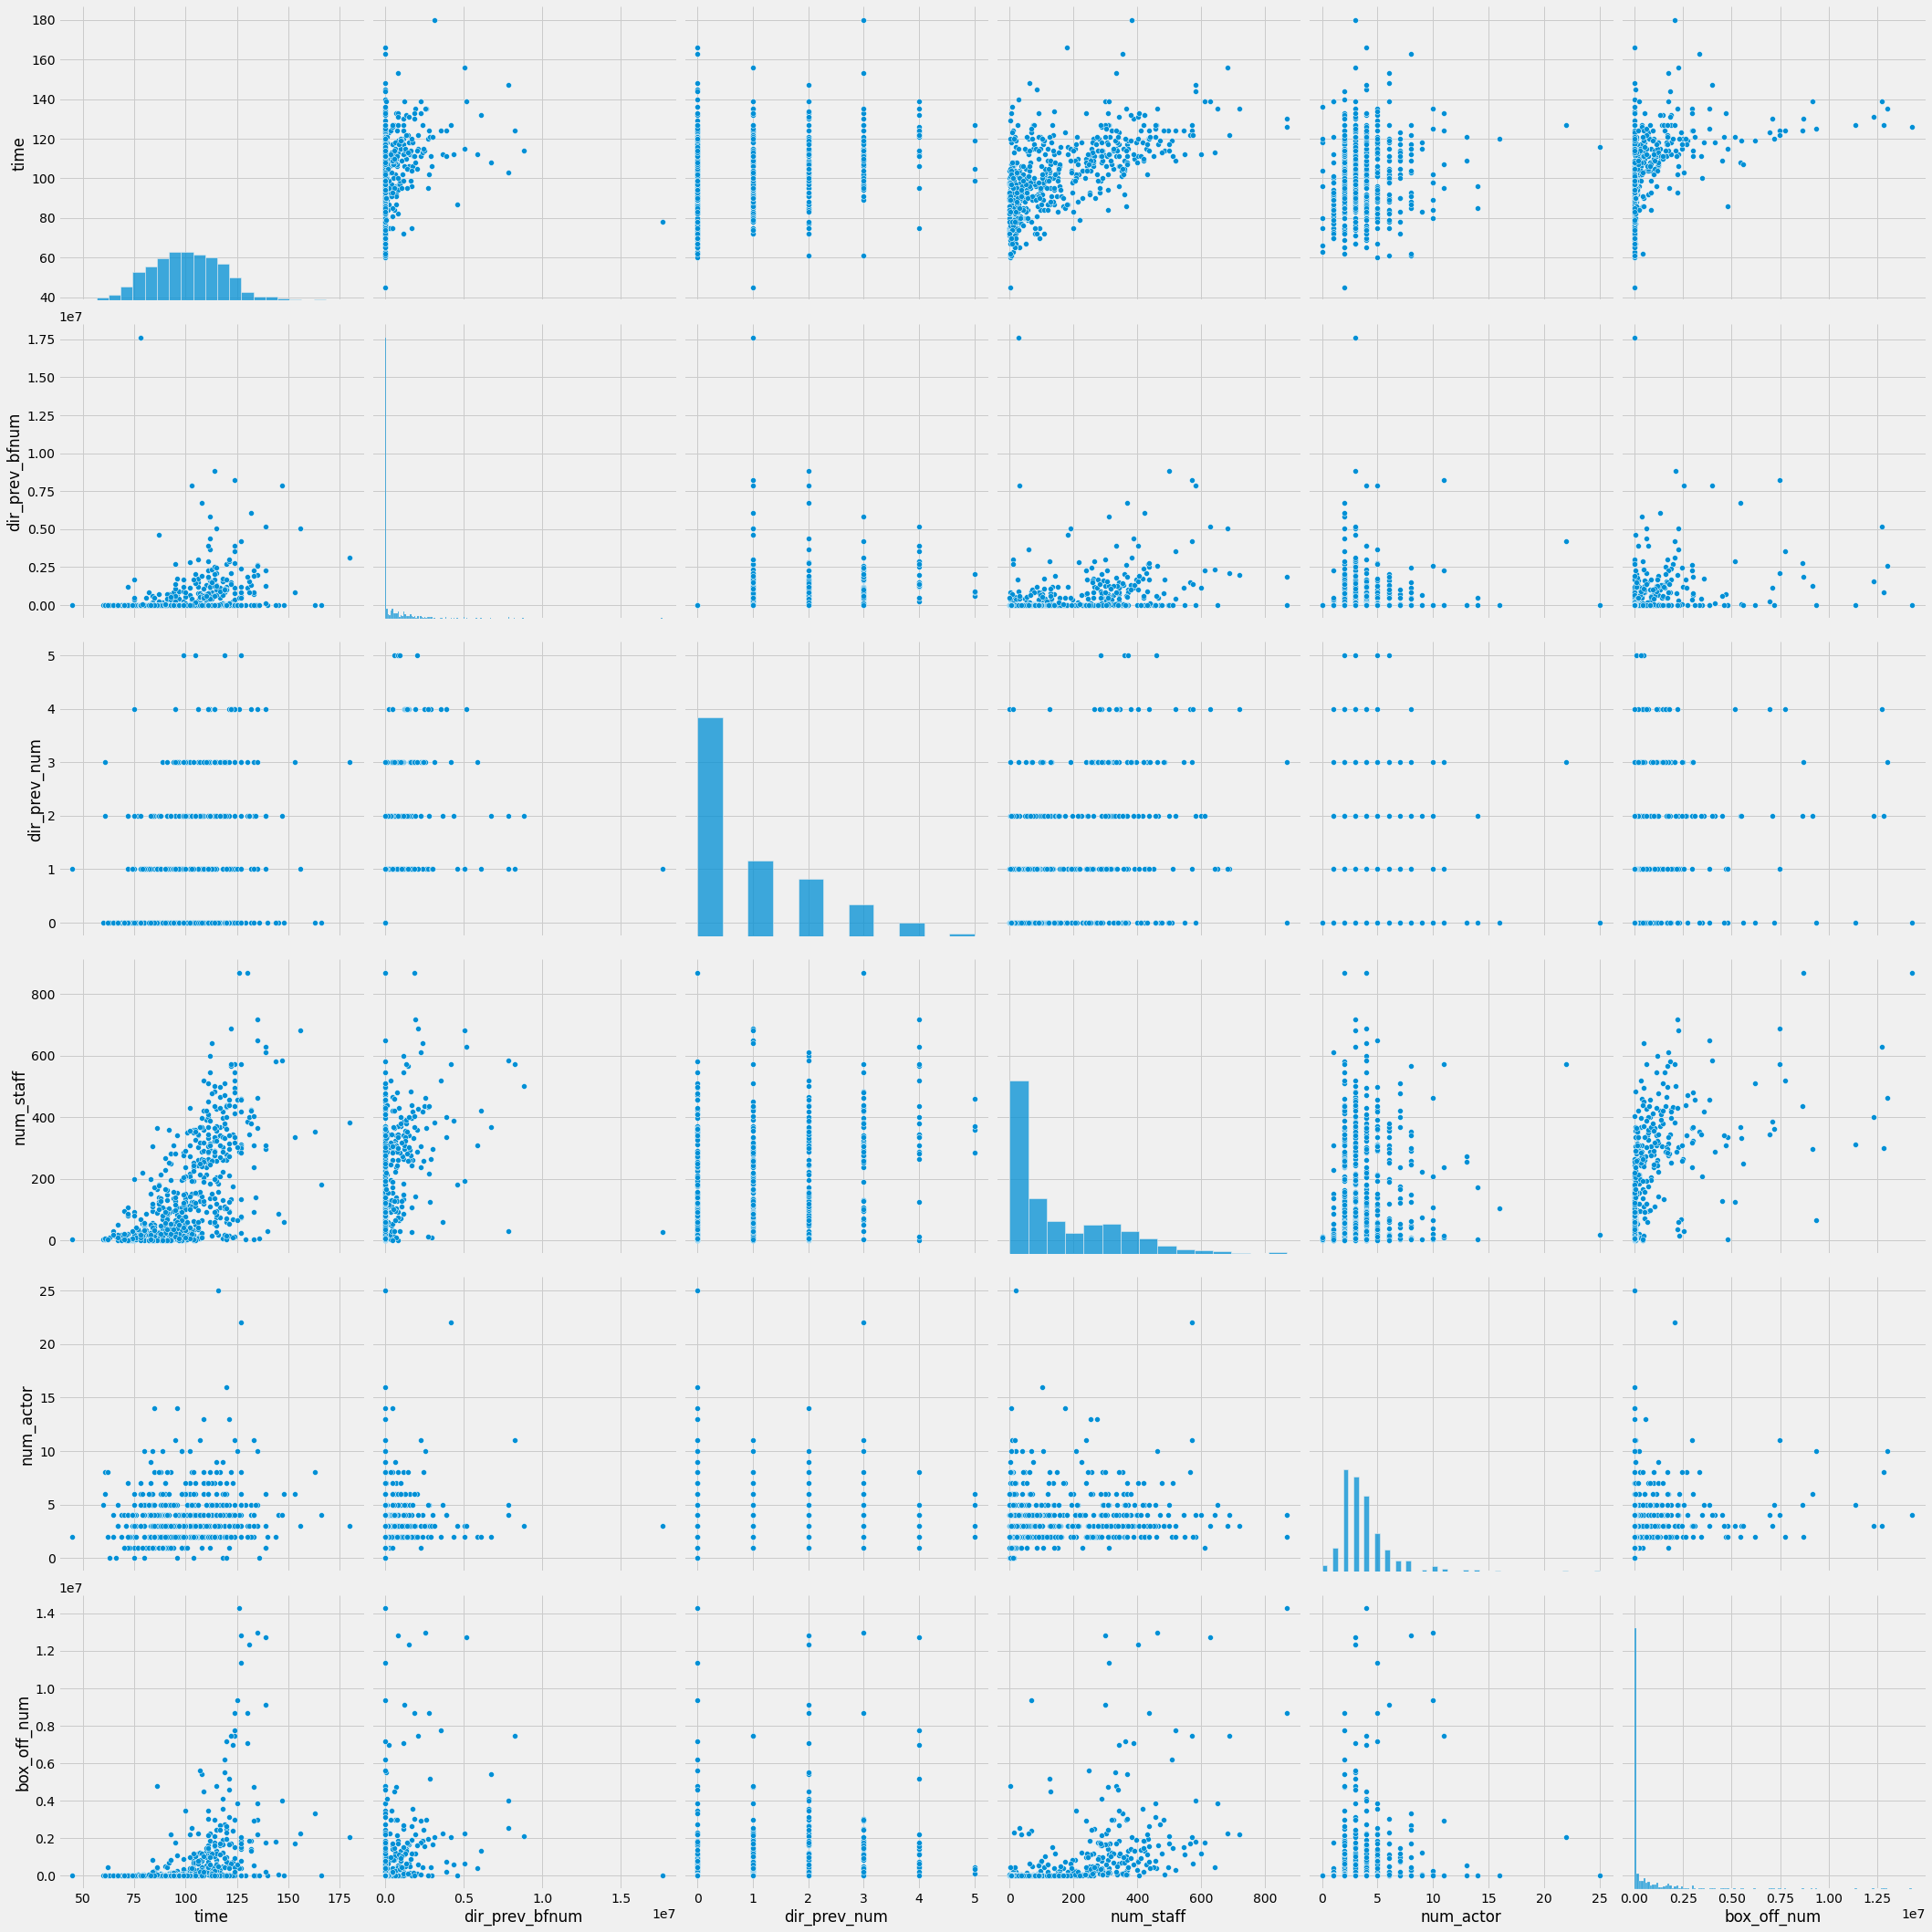

In [63]:
sns.pairplot(data=df, vars=num_cols + [target_col], size=5)
# time은 정규분포에 가깝고, 나머지는 멱함수 분포에 가까움

In [64]:
df.corr().style.background_gradient()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000


### Linear Regression

In [65]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmsle = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

In [66]:
lr = LinearRegression()
lr.fit(df[num_cols], df[target_col])
df[pred_col] = lr.predict(df[num_cols])

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1500066.43


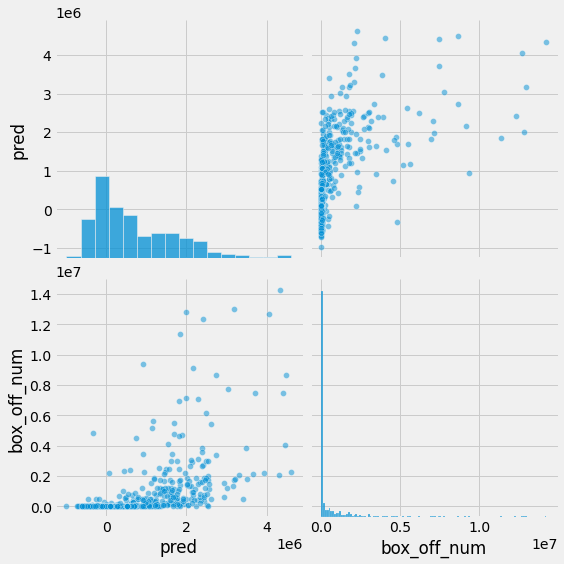

In [67]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})
# 음수 예측, 낮은 값의 예측이 특히 부정확함

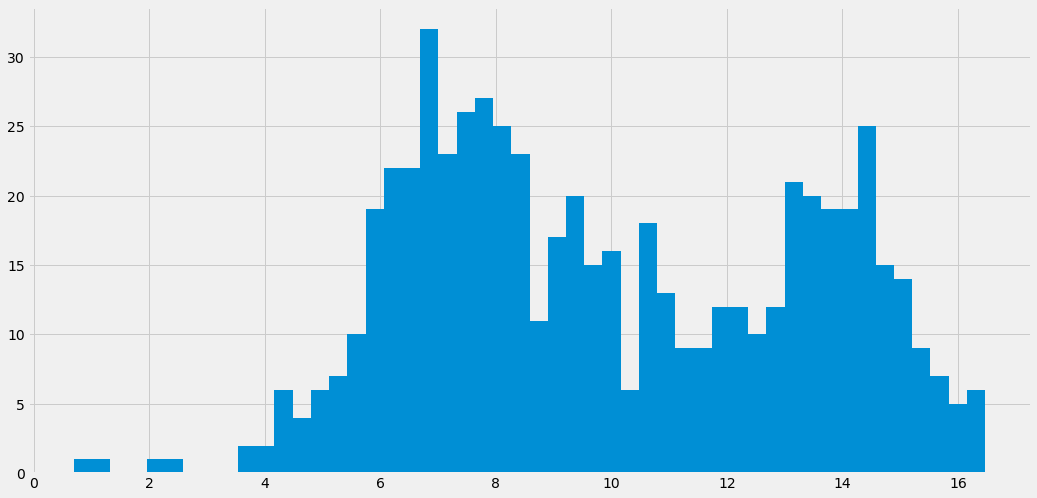

In [68]:
df.box_off_num.apply(np.log1p).hist(bins=50)

In [69]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	 17129211.69
RMSLE:	        2.12


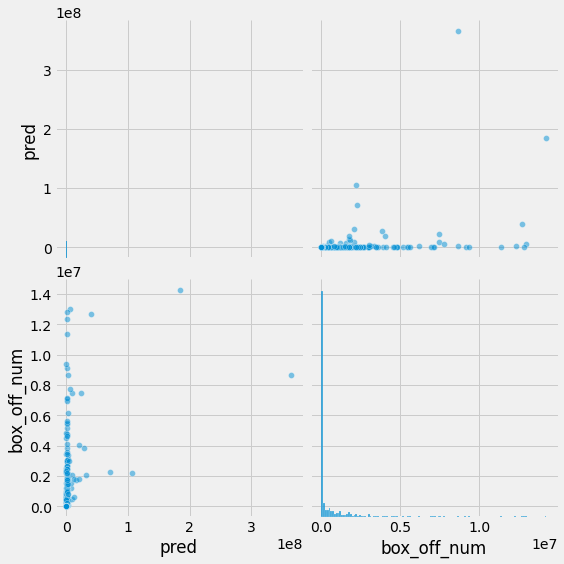

In [70]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

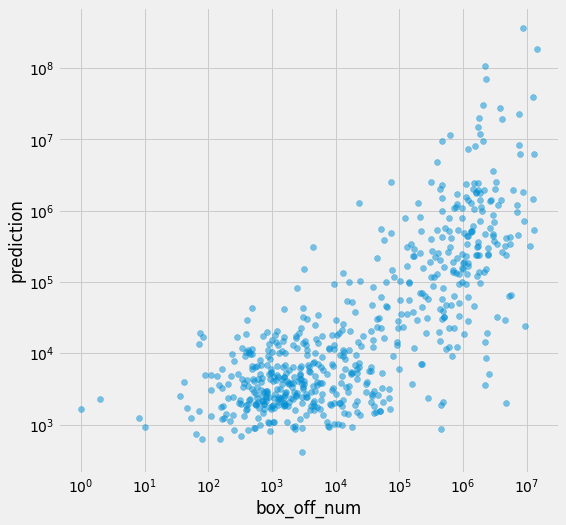

In [71]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [72]:
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000


In [73]:
df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']].apply(np.log1p)
# time 외에는 멱함수 분포를 따르므로 log1p 적용
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,100.863333,5.305796,0.462197,4.026352,1.446130
std,18.097528,6.254561,0.555570,1.789517,0.446256
min,45.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000,0.000000,2.890372,1.098612
50%,100.000000,0.000000,0.000000,4.424829,1.386294
75%,114.000000,12.837611,1.098612,5.579730,1.609438
max,180.000000,16.684279,1.791759,6.768493,3.258097


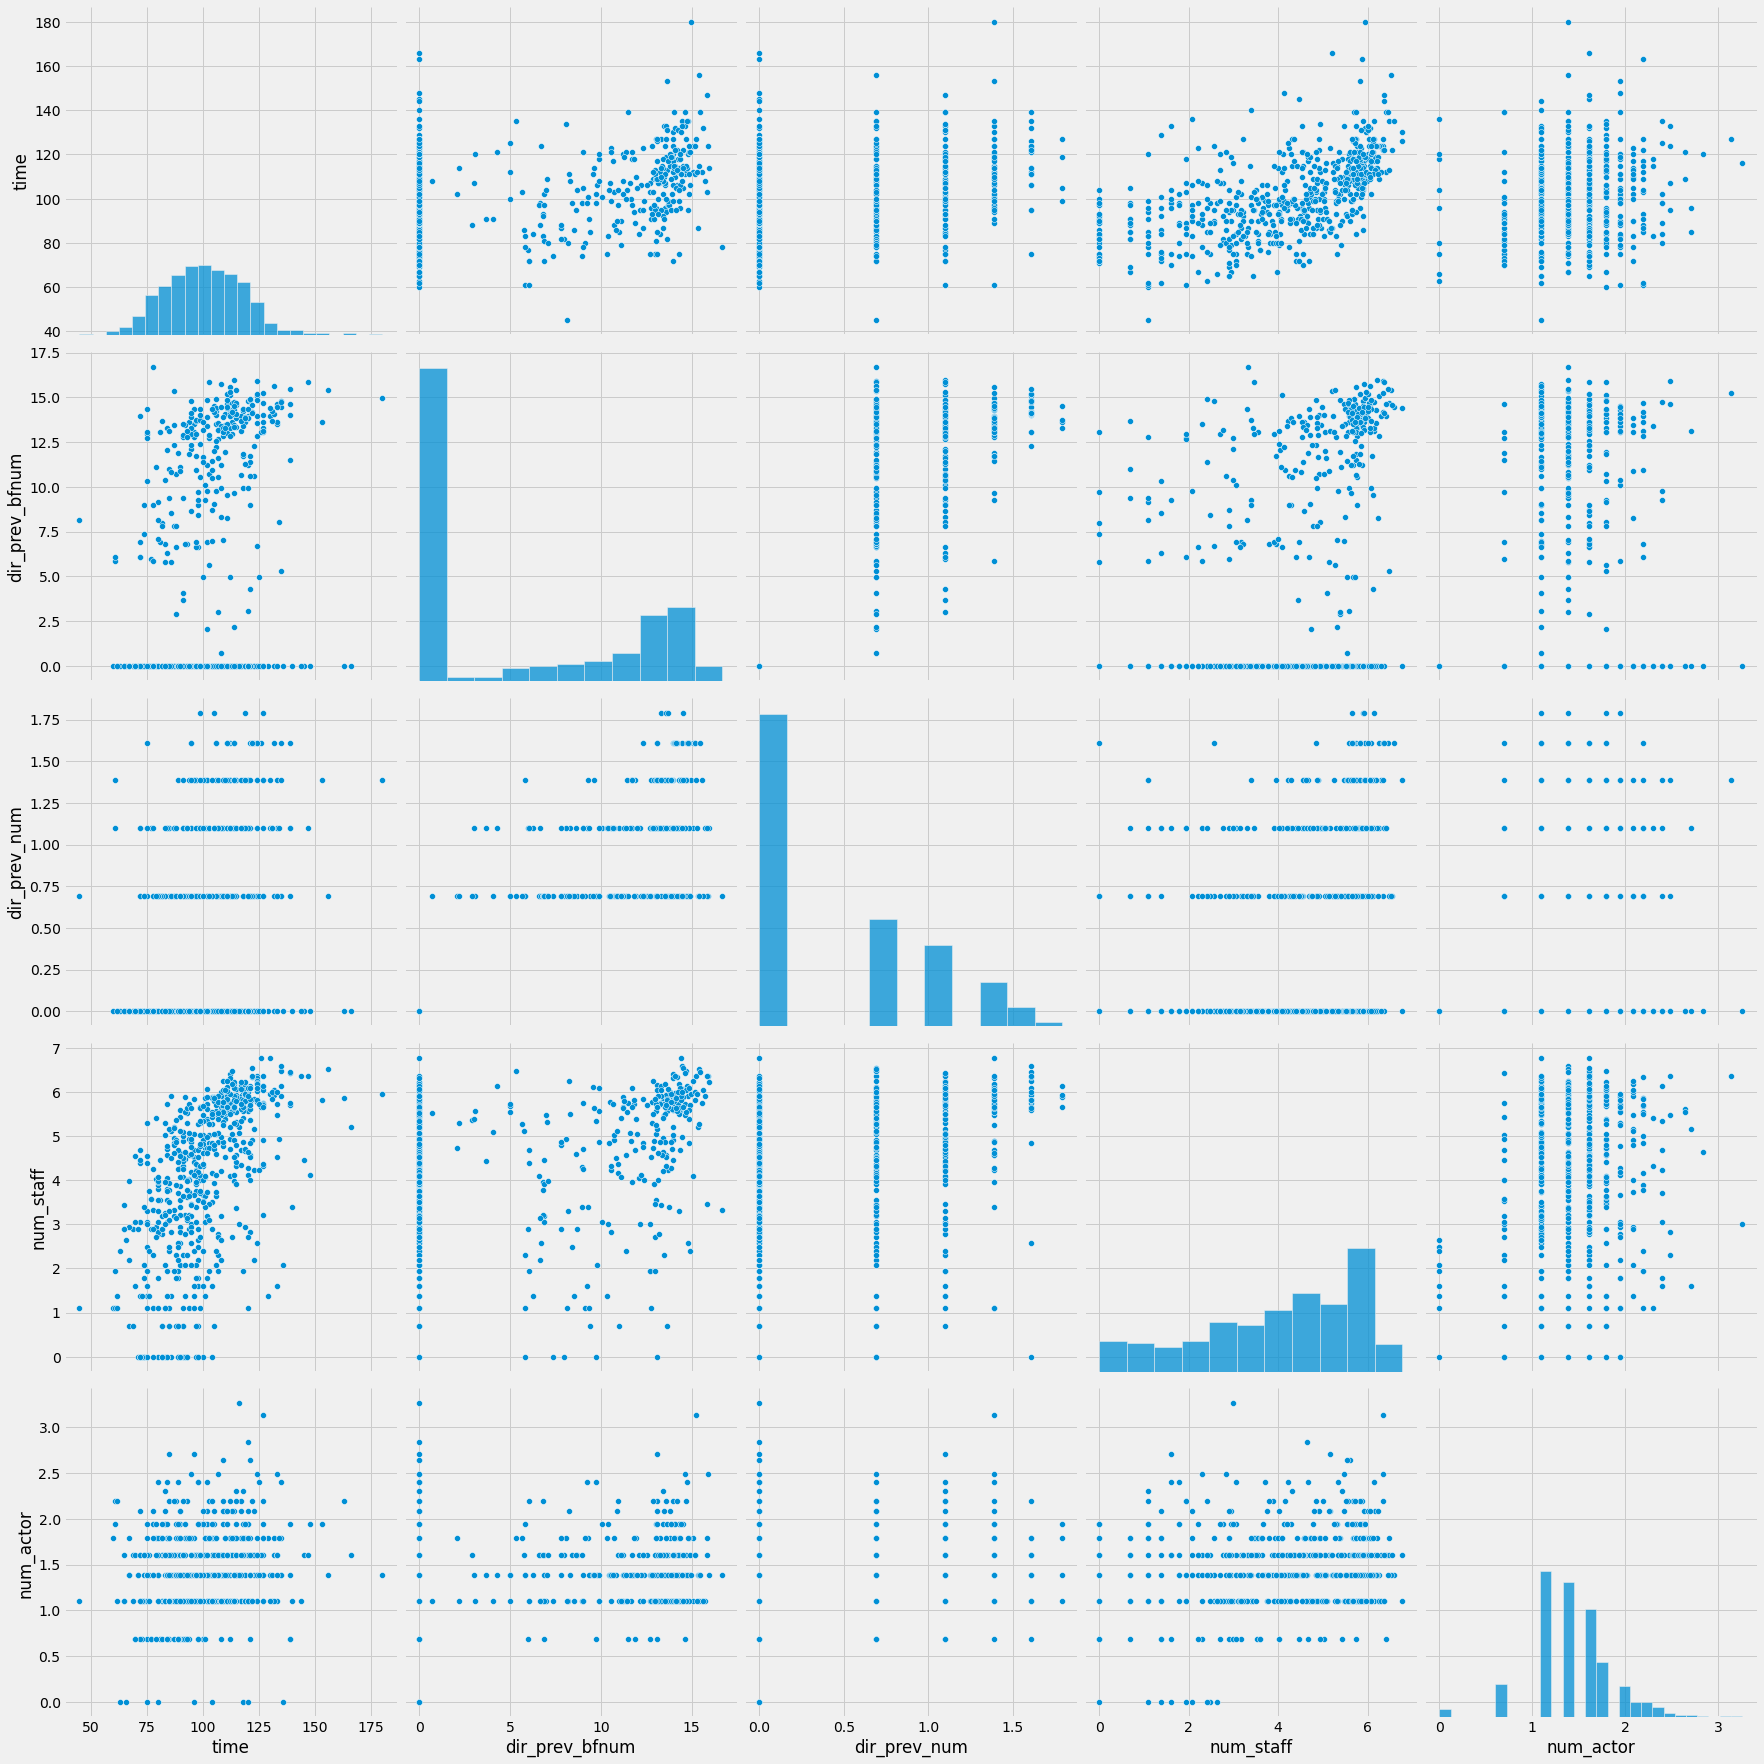

In [74]:
sns.pairplot(data=df, vars=num_cols, size=5)

In [75]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}') # 8자리에서 7자리로 큰 폭의 감소
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMSLE:	        2.32


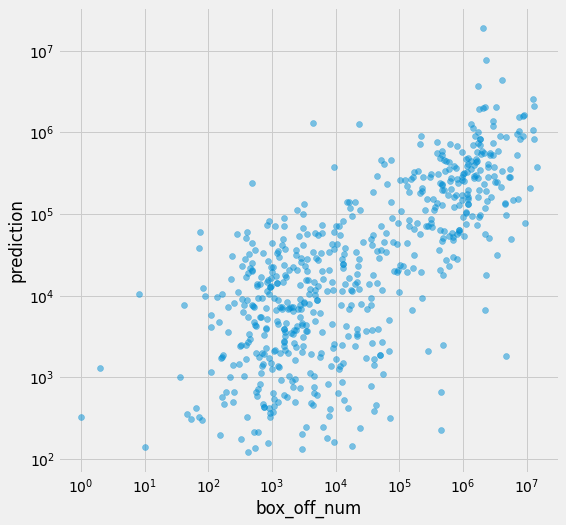

In [76]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [77]:
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred
title,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863


In [78]:
df['release_time'] = pd.to_datetime(df['release_time'])
df['release_time'].describe()

count                     600
unique                    330
top       2015-08-13 00:00:00
freq                        6
first     2010-01-02 00:00:00
last      2015-12-31 00:00:00
Name: release_time, dtype: object

In [79]:
df['year'] = df['release_time'].dt.year
df['month'] = df['release_time'].dt.month
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred,year,month
title,,,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433,2012,11
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247,2015,11
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465,2013,6
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119,2012,7
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863,2010,11


In [80]:
num_cols += ['year', 'month']
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'year', 'month']


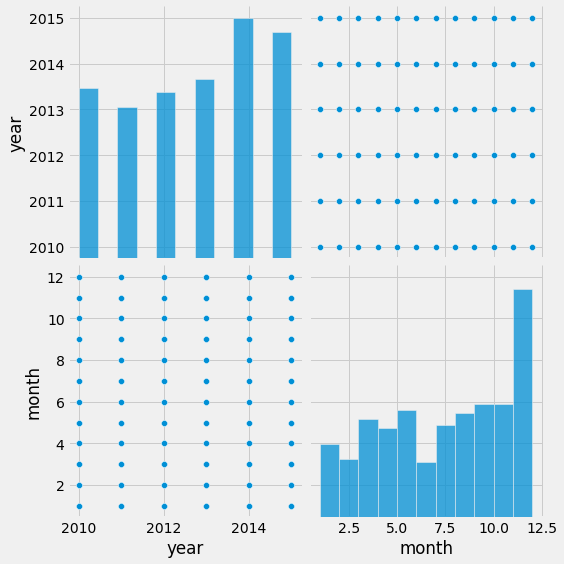

In [81]:
sns.pairplot(data=df, vars=['year', 'month'], size=4)

In [83]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMSLE:	        2.31


In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [84]:
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMSLE:	        2.31


In [87]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMSLE:	        2.31


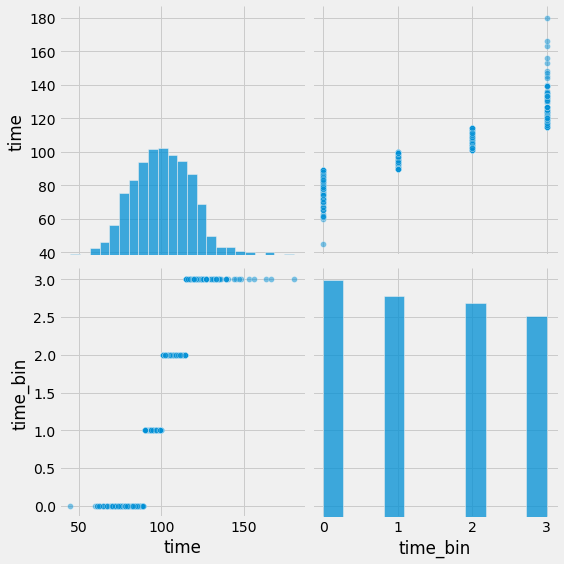

In [86]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
sns.pairplot(data=df, vars=['time', 'time_bin'], size=4, plot_kws={'alpha': .5})

In [88]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
df[['time', 'time_bin']].head(10)

,time,time_bin
title,,
개들의 전쟁,96,1
내부자들,130,3
은밀하게 위대하게,123,3
나는 공무원이다,101,2
불량남녀,108,2
강철대오 : 구국의 철가방,113,2
길위에서,104,2
회사원,96,1
"1789, 바스티유의 연인들",129,3


In [89]:
X = pd.concat([df[num_cols], pd.get_dummies(pd.qcut(df['time'], 4, labels=False))], axis=1)
X.shape
X.head()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month,0,1,2,3
title,,,,,,,,,,,
개들의 전쟁,96,0.000000,0.000000,4.521789,1.098612,2012,11,0,1,0,0
내부자들,130,13.965312,1.098612,5.961005,1.386294,2015,11,0,0,0,1
은밀하게 위대하게,123,12.304905,1.609438,5.840642,1.609438,2013,6,0,0,0,1
나는 공무원이다,101,10.081425,1.098612,3.044522,1.945910,2012,7,0,0,1,0
불량남녀,108,0.693147,0.693147,5.529429,1.098612,2010,11,0,0,1,0


In [90]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1730191.35
RMSLE:	        2.25


get_dummies 사용하는 이유?  
수치화 과정에서 발생한 관계성을 없애기 위해서   
e.g. 1월 = 1, 2월 = 2, ... -> 이때 1 + 2 = 3의 관계가 존재하는가? X  
보다 구체적인 내용은 [해당 블로그 포스트](https://devuna.tistory.com/67) 참고


In [91]:
X = pd.concat([df[[x for x in num_cols if x != 'month']], # month drop하고 get_dummies로 12달을 추가
               pd.get_dummies(pd.qcut(df['time'], 4, labels=False)),
               pd.get_dummies(df['month'])], axis=1)
X.shape
X.head()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,0,1,2,3,1,2,3,4,5,6,7,8,9,10,11,12
title,,,,,,,,,,,,,,,,,,,,,,
개들의 전쟁,96,0.000000,0.000000,4.521789,1.098612,2012,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
내부자들,130,13.965312,1.098612,5.961005,1.386294,2015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
은밀하게 위대하게,123,12.304905,1.609438,5.840642,1.609438,2013,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
나는 공무원이다,101,10.081425,1.098612,3.044522,1.945910,2012,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
불량남녀,108,0.693147,0.693147,5.529429,1.098612,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [92]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1693164.29
RMSLE:	        2.22


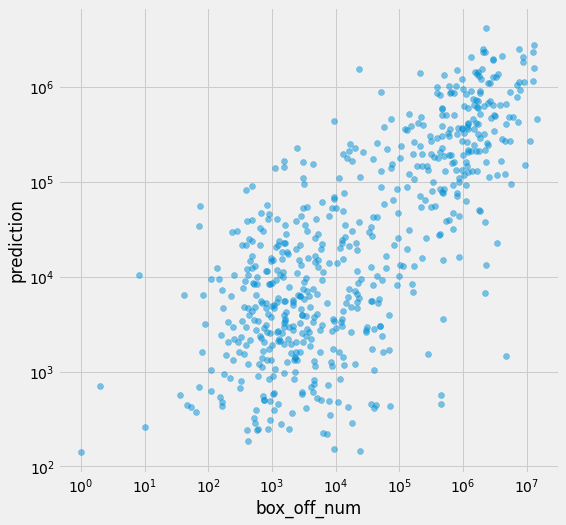

In [93]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [94]:
from sklearn.preprocessing import PolynomialFeatures

In [95]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[num_cols])
print(X.shape)

(600, 36)


In [96]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMSLE:\t{rmsle(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  2925429.78
RMSLE:	        2.00


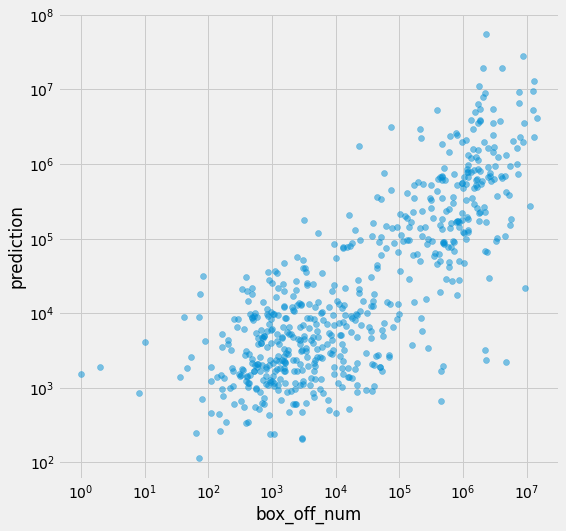

In [97]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')